# Deep Q-Network (DQN)

## 1. Rappel : Q-Learning

On cherche à approximer la fonction de valeur optimale :

$$
Q^*(s,a)
$$

L'équation de Bellman optimale est :

$$
Q^*(s,a) = \mathbb{E}\left[ r + \gamma \max_{a'} Q^*(s',a') \mid s,a \right]
$$

En Q-learning tabulaire, la mise à jour est :

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right)
$$

---

## 2. Approximation par réseau de neurones

Lorsque l'espace d'état est continu ou très grand, on approxime :

$$
Q(s,a;\theta)
$$

où $\theta$ sont les paramètres du réseau.

On définit la cible :

$$
y = r + \gamma \max_{a'} Q(s',a';\theta)
$$

et on minimise la perte quadratique :

$$
\mathcal{L}(\theta) = \mathbb{E}\left[ \left( y - Q(s,a;\theta) \right)^2 \right]
$$

---

## 3. Problème d'instabilité

Le problème fondamental est que la cible dépend des mêmes paramètres :

$$
y = r + \gamma \max_{a'} Q(s',a';\theta)
$$

On optimise un réseau dont la cible dépend de lui-même.

Cela peut provoquer :
- oscillations
- divergence
- surestimation des valeurs.

C'est le problème du bootstrap combiné à l'approximation fonctionnelle et à l'apprentissage off-policy.

---

## 4. Stabilisation : Deep Q-Network

DQN introduit deux mécanismes essentiels.

### 4.1 Target Network

On introduit un second réseau :

$$
Q(s,a;\theta^-)
$$

où $\theta^-$ est une copie figée des paramètres.

La cible devient :

$$
y = r + \gamma \max_{a'} Q(s',a';\theta^-)
$$

Les paramètres sont mis à jour périodiquement :

$$
\theta^- \leftarrow \theta
$$

Cela rend la cible quasi-stationnaire.

---

### 4.2 Experience Replay

On stocke les transitions :

$$
(s, a, r, s', \text{done})
$$

dans un buffer.

On entraîne le réseau sur des mini-batchs échantillonnés aléatoirement.

Objectifs :
- casser la corrélation temporelle,
- améliorer l'efficacité des données,
- stabiliser l'apprentissage.

---

## 5. Perte finale utilisée dans DQN

Pour un mini-batch :

$$
y_i =
\begin{cases}
r_i & \text{si terminal} \\
r_i + \gamma \max_{a'} Q(s'_i,a';\theta^-) & \text{sinon}
\end{cases}
$$

La fonction de perte est :

$$
\mathcal{L}(\theta) =
\frac{1}{N} \sum_i \left( y_i - Q(s_i,a_i;\theta) \right)^2
$$

---

## 6. Politique utilisée

La politique est $\epsilon$-greedy :

$$
\pi(a|s) =
\begin{cases}
\text{action aléatoire} & \text{avec probabilité } \epsilon \\
\arg\max_a Q(s,a;\theta) & \text{sinon}
\end{cases}
$$

---

## 7. Résumé

DQN repose sur :

- l'approximation fonctionnelle de $Q$,
- le bootstrap via l'équation de Bellman,
- un target network pour stabiliser la cible,
- un replay buffer pour casser les corrélations,
- une optimisation par mini-batch.

Sans target network ni replay buffer, l'entraînement est généralement instable.

In [32]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 


In [33]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
# on s'assure ici qu'on utlise bien le GPU pour les calculs

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

Torch version: 2.11.0.dev20260215+cu128
CUDA available: True
CUDA version: 12.8
Number of GPUs: 1
Device: cuda
GPU name: NVIDIA GeForce RTX 5090


In [34]:
env = gym.make("CartPole-v1")
# on utlise encore le même exempel que pour les autres algos pour pouvoir comparer les résultats

state_dim = env.observation_space.shape[0]
# on a encore la position et l'angle du pole, ainsi que leurs dérivées
n_actions = env.action_space.n

print("State dim:", state_dim)
print("Number of actions:", n_actions)

State dim: 4
Number of actions: 2


In [35]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
# On utlise un réseau simple de 3 couches cachées de 128 neurones chacune, avec des activations ReLU. 
# La sortie est de taille n_actions, donnant la valeur de chaque action possible dans l'état donné.
# On pourrait tester d'autres architectures, mais celle-ci est un bon point de départ pour ce type d'environnement.

    def forward(self, x):
        return self.net(x)
    
    #la focntion forward est très simple, elle passe juste l'entrée dans le réseau pour obtenir les Q-values.

In [36]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        # le replay buffer est une structure de données qui stocke les transitions (state, action, reward, next_state, done) 
        # rencontrées pendant l'entraînement. Il permet de réutiliser ces transitions pour entraîner le réseau de manière plus 
        # efficace et stable. On utilise une deque avec une capacité maximale pour éviter que le buffer ne devienne trop grand 
        # et consomme trop de mémoire.

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        # la méthode push ajoute une transition au buffer. Si le buffer est plein, la transition la plus ancienne sera automatiquement 
        # supprimée grâce à l'utilisation de deque.

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        # la méthode sample prélève un échantillon aléatoire de transitions du buffer. Elle retourne les états, actions, récompenses, 
        # états suivants et indicateurs de fin d'épisode sous forme de tenseurs PyTorch, prêts à être utilisés pour l'entraînement du réseau.
        # l'utilisation de torch.tensor avec les bons types de données  est nécessaire pour des raisosn de compatibilité avec le réseau de neurones
        # et les opérations de calcul sur GPU.

        return (
            torch.tensor(states, dtype=torch.float32, device=device),
            torch.tensor(actions, dtype=torch.long, device=device),
            torch.tensor(rewards, dtype=torch.float32, device=device),
            torch.tensor(next_states, dtype=torch.float32, device=device),
            torch.tensor(dones, dtype=torch.float32, device=device),
        )

    def __len__(self):
        return len(self.buffer)

In [37]:
# Hyperparamètres
gamma = 0.99 #facteur de discount, qui détermine l'importance des récompenses futures par rapport aux récompenses immédiates.
lr = 1e-3 #learning rate de l'optimiseur Adam, qui contrôle la vitesse à laquelle le réseau de neurones apprend. 
# Un lr trop élevé peut rendre l'entraînement instable, tandis qu'un lr trop bas peut ralentir l'apprentissage.
batch_size = 64 # taille des mini-batchs prélevés du replay buffer pour entraîner le réseau à chaque étape. 
# Un batch_size plus grand peut stabiliser l'entraînement, mais nécessite plus de mémoire et de temps de calcul.
buffer_capacity = 100_000 # capacité maximale du replay buffer, c'est-à-dire le nombre maximum de transitions qu'il peut stocker.
min_buffer_size = 1_000 # nombre minimum de transitions dans le replay buffer avant de commencer l'entraînement du réseau.
target_update_freq = 1_000  # nombre de steps entre chaque mise à jour du réseau cible, qui est utilisé pour calculer les cibles de Q-learning.

epsilon_start = 1.0 # valeur initiale de epsilon pour la stratégie epsilon-greedy, on commence par explorer complètement l'environnement.
epsilon_end = 0.05 # valeur finale de epsilon, qui détermine le taux d'exploration minimum. 
epsilon_decay = 5000  # vitesse de décroissance de epsilon, qui contrôle à quelle vitesse epsilon passe de sa valeur initiale à sa valeur finale.

# Réseaux
q_net = QNetwork(state_dim, n_actions).to(device) # on crée le réseau de neurones principal qui va apprendre à estimer les Q-values pour chaque action dans chaque état.
target_net = QNetwork(state_dim, n_actions).to(device) # on crée un réseau cible qui sera utilisé pour calculer les cibles de Q-learning. 
# Ce réseau est une copie du réseau principal, mais il est mis à jour moins fréquemment pour stabiliser l'entraînement.
target_net.load_state_dict(q_net.state_dict()) # on initialise le réseau cible avec les mêmes poids que le réseau principal. 
# Par la suite, le réseau cible sera mis à jour périodiquement
target_net.eval() # on met le réseau cible en mode évaluation, car il ne sera pas entraîné directement. Cela désactive des fonctionnalités
# comme le dropout ou la batch normalization, qui ne sont pas nécessaires pour le réseau cible 

optimizer = optim.Adam(q_net.parameters(), lr=lr) # Adam, très classique

replay_buffer = ReplayBuffer(buffer_capacity) # on crée le replay buffer avec la capacité définie précédemment.


In [38]:
def epsilon_by_step(step):
    return epsilon_end + (epsilon_start - epsilon_end) * np.exp(-step / epsilon_decay) 
#mise à jour de epsilon à chaque étape, en utilisant une décroissance exponentielle. Cela permet de réduire progressivement 
# le taux d'exploration au fur et à mesure que l'agent apprend, tout en assurant qu'il continue à explorer suffisamment pour 
# éviter de se coincer dans des minima locaux.


def select_action(state, step):
    epsilon = epsilon_by_step(step)
    # on met à jou repsilon 
    
    if random.random() < epsilon:
        return random.randrange(n_actions)
    # on choisit une action aléatoire avec une probabilité epsilon 
    
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    # on convertit l'état en un tenseur PyTorch et on ajoute une dimension batch (unsqueeze(0)) pour le passer dans le réseau.

    with torch.no_grad(): # on désactive le calcul des gradients pour cette partie, car on n'a pas besoin de rétropropagation 
                          # lors de la sélection d'action.
        q_values = q_net(state) # on passe l'état dans le réseau pour obtenir les Q-values de chaque action possible.
    return q_values.argmax(dim=1).item() # on choisit l'action avec la plus grande Q-value, c'est-à-dire l'action que 
                                         # le réseau estime être la meilleure dans l'état donné.

In [39]:
def dqn_update():
    if len(replay_buffer) < min_buffer_size:
        return None # on ne commence l'entraînement du réseau que lorsque le replay buffer contient suffisamment de transitions,
                    # pour éviter d'entraîner sur des échantillons trop petits et non représentatifs de l'environnement.

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    # mise à jour du réseau de neurones en utilisant un mini-batch de transitions prélevé du replay buffer.

    # Q(s,a)
    q_values = q_net(states) # on passe les états du mini-batch dans le réseau pour obtenir les Q-values
    q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1) # on sélectionne les Q-values correspondant aux actions prises dans le mini-batch, 
    # en utilisant gather pour indexer les actions et squeeze pour enlever la dimension inutile après la sélection.

    # Cible
    with torch.no_grad(): #désactivé pour le calcul des gradients, car on n'entraîne pas le réseau cible directement.
        next_actions = q_net(next_states).argmax(dim=1, keepdim=True) # on utilise le réseau principal pour choisir les actions suivantes
        next_q_values = target_net(next_states).gather(1, next_actions).squeeze(1) # on utilise le réseau cible pour obtenir les Q-values des actions suivantes
        targets = rewards + gamma * next_q_values * (1 - dones) # on calcule les cibles de Q-learning en utilisant la récompense immédiate plus la valeur estimée 
        # des actions suivantes

    loss = nn.MSELoss()(q_values, targets) # calcul de la loss en utilisant l'erreur quadratique moyenne entre les Q-values prédites par le réseau et les cibles calculées.

    optimizer.zero_grad() # on remet à zéro les gradients de l'optimiseur avant de faire la rétropropagation, pour éviter que les gradients ne s'accumulent d'une étape à l'autre.
    loss.backward() # on calcule les gradients de la loss par rapport aux paramètres du réseau en utilisant la rétropropagation.
    optimizer.step() # on met à jour les paramètres du réseau en utilisant les gradients calculés et l'optimiseur Adam.

    return loss.item()

Attention : la cellule suivante correspond à l’entraînement du modèle. Les poids ont déjà été sauvegardés dans un fichier séparé ; il n’est donc pas nécessaire d’exécuter cette cellule à nouveau sauf si l’on souhaite relancer l’entraînement.

In [40]:
num_episodes = 1000 # nombre d'épisodes d'entraînement, c'est-à-dire le nombre de fois que l'agent va interagir avec l'environnement pour apprendre.
max_steps = 500 # nombre maximum de steps par épisode, pour éviter que les épisodes ne durent indéfiniment 

step_count = 0 # compteur global de steps, utilisé pour la mise à jour du réseau cible et le calcul de epsilon.
episode_rewards = [] # liste pour stocker les récompenses totales obtenues à la fin de chaque épisode, afin de suivre les performances de l'agent au fil du temps.
losses = [] # liste pour stocker les valeurs de loss à chaque étape d'entraînement, afin de suivre l'évolution de la loss au fil du temps et de diagnostiquer 
# d'éventuels problèmes d'entraînement.

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0 # initialisation de la récompense totale pour cet épisode, qui sera mise à jour à chaque étape en ajoutant la récompense obtenue.

    for t in range(max_steps):
        action = select_action(state, step_count) # choix de l'action avec la stratégie epsilon-greedy et en utilisant Q-net
        next_state, reward, terminated, truncated, _ = env.step(action) # on exécute l'action dans l'environnement pour obtenir le nouvel état, la récompense, 
        # et les indicateurs de fin d'épisode.
        done = terminated or truncated

        replay_buffer.push(state, action, reward, next_state, done) # on stocke la transition dans le replay buffer pour pouvoir l'utiliser plus tard pour entraîner le réseau.

        state = next_state
        total_reward += reward
        step_count += 1

        loss = dqn_update() # on effectue une mise à jour du réseau à chaque étape, en utilisant un mini-batch de transitions prélevé du replay buffer.
        if loss is not None:
            losses.append(loss)

        # Mise à jour target network
        if step_count % target_update_freq == 0:
            target_net.load_state_dict(q_net.state_dict()) # on met à jour le réseau cible en copiant les poids du réseau principal 
            # si on a atteint le nombre de steps défini pour la mise à jour.

        if done:
            break

    episode_rewards.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}, Reward: {total_reward}")
    
torch.save(q_net.state_dict(), "dqn_cartpole.pt") # on sauvegarde les poids du réseau principal dans un fichier "dqn_cartpole.pt" 
# pour pouvoir les réutiliser plus tard sans avoir à réentraîner le modèle.
print("Model saved.") 


Episode 100, Reward: 10.0
Episode 200, Reward: 39.0
Episode 300, Reward: 136.0
Episode 400, Reward: 162.0
Episode 500, Reward: 94.0
Episode 600, Reward: 118.0
Episode 700, Reward: 106.0
Episode 800, Reward: 321.0
Episode 900, Reward: 183.0
Episode 1000, Reward: 139.0
Model saved.


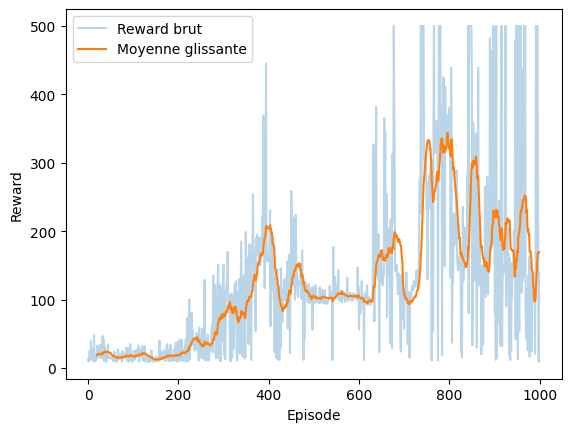

In [41]:
window = 20
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')

plt.figure()
plt.plot(episode_rewards, alpha=0.3, label="Reward brut")
plt.plot(range(window-1, len(episode_rewards)), moving_avg, label="Moyenne glissante")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

In [42]:
q_net = QNetwork(state_dim, n_actions).to(device) # on recrée le réseau de neurones principal pour pouvoir charger les poids sauvegardés 
# et réutiliser le modèle sans avoir à réentraîner.
q_net.load_state_dict(torch.load("dqn_cartpole.pt", map_location=device)) # on charge les poids sauvegardés dans le réseau
q_net.eval() # on passe en mode éval 

QNetwork(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [43]:
def greedy_action(state):
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        q_values = q_net(state)
    return q_values.argmax(dim=1).item()
# la fonction greedy_action permet de choisir l'action avec la plus grande Q-value pour un état donné, en utilisant le réseau de neurones entraîné.

In [44]:
def evaluate(n_episodes=20):
    q_net.eval()
    rewards = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = greedy_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

        rewards.append(total_reward)

    return np.mean(rewards), np.std(rewards)

In [51]:
mean_reward, std_reward = evaluate(50)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Mean reward: 90.06 ± 37.69


## Aaméliorations possibles et transition

Les résultats montrent que l’agent apprend à résoudre CartPole mais avec des oscillations importantes.  
C’est typique des méthodes value-based avec bootstrap et approximation fonctionnelle.


On peut stabiliser l’apprentissage en ajustant :

- **Learning rate**  
  `lr = 5e-4`  
  → gradients plus stables.

- **Fréquence du target network**  
  `target_update_freq = 200`  
  → cible plus réactive.

- **Batch size**  
  `batch_size = 128`  
  → réduction de la variance des gradients.

- **Loss Huber**  
  `nn.SmoothL1Loss()`  
  → plus robuste que MSE.

- **Décroissance d’epsilon plus rapide**  
  `epsilon_decay = 3000`  
  → exploitation plus précoce.

Même avec ces réglages, DQN reste sensible car la cible dépend d’un réseau appris (bootstrap), ce qui peut provoquer des oscillations.

---